# Model Creation and Training

In [1]:
# importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imgaug import augmenters as iaa
import random

### Load Dataset

(6000, 96, 96) (6000, 4)


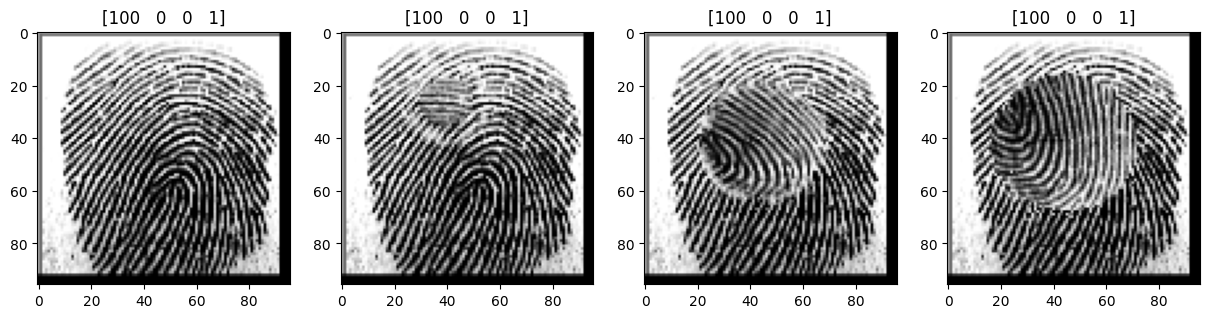

In [2]:
# loading the dataset

x_real = np.load('datasets/x_real.npy')
y_real = np.load('datasets/y_real.npy')
x_easy = np.load('datasets/x_easy.npy')
y_easy = np.load('datasets/y_easy.npy')
x_medium = np.load('datasets/x_medium.npy')
y_medium = np.load('datasets/y_medium.npy')
x_hard = np.load('datasets/x_hard.npy')
y_hard = np.load('datasets/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

### Train Test Split


In [3]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

print(len(x_data))
print(len(label_data))

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size= 0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

42814
42814
(42814, 96, 96) (42814, 4)
(38532, 96, 96) (38532, 4)
(4282, 96, 96) (4282, 4)


### Preview augmentation

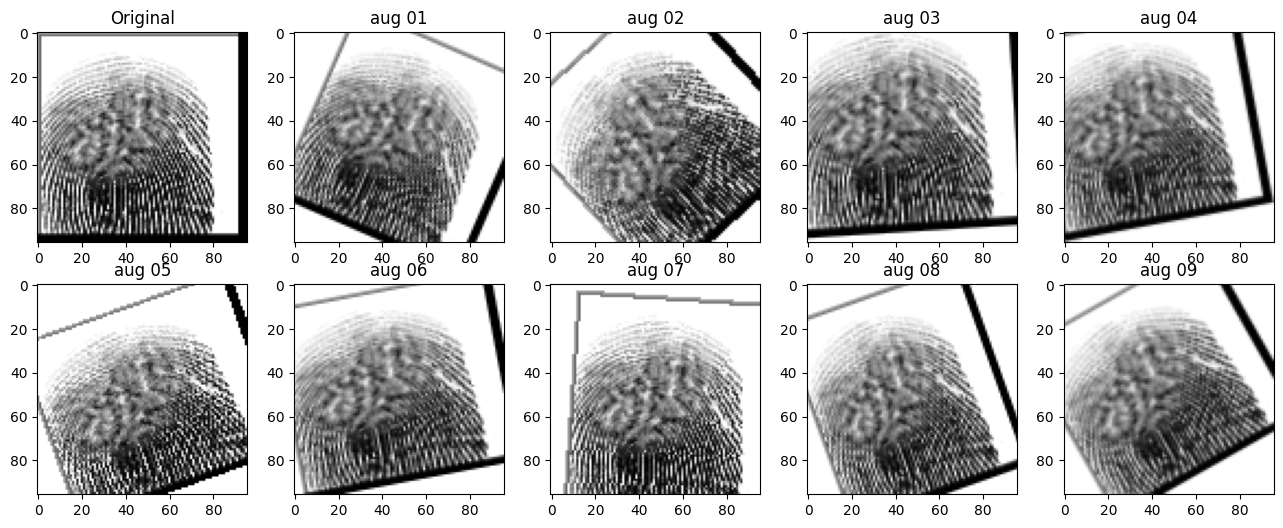

In [4]:
augs = [x_data[40000]]*9

seq = iaa.Sequential([
    #Blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        #scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        #translate by -10 to +10% of their height/width (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        #rotate by -45 to +45 degrees
        rotate=(-45, 45),
        #use nearest neighbour or bilinear interpolation (fast)
        order=[0,1],
        #if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16,6))
plt.subplot(2,5,1)
plt.title('Original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2,5,i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

### Make Label Dictionary Lookup table

In [5]:
Label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)
    
    Label_real_dict[key] = i

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x,  label,X_real, Label_real_dict, batch_size= 32, shuffle=True):
        "Initialization"
        self.x = x
        self.label = label
        self.x_real = x_real
        self.Label_real_dict = Label_real_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        "denotes the number of batches per epoch"
        return int(np.floor(len(self.x)/self.batch_size))
    
    def __getitem__(self, index):
        "Generates one batch of data"
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96), dtype = np.float32)
        y_batch = np.empty((self.batch_size), dtype = np.float32)
        
        #augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-45, 45),
                    order = [0,1],
                    cval = 255
                ),
                iaa.Add((-10, 10)),
                iaa.Multiply((0.5, 1.5)),
                iaa.Fliplr(0.5)
            ], random_order= True)
            
            x1_batch = seq.augment_images(x1_batch)
            
    # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
    # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)
            
            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.Label_real_dict[match_key]]
                y_batch[i] = 1.
                
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_index = random.choice(list(self.Label_real_dict.items()))
                    
                    if unmatch_key != match_key:
                        break
                
                x2_batch[i] = self.x_real[unmatch_index]
                y_batch[i] = 0.
    
        return [x1_batch.astype(np.float32)/255., x2_batch.astype(np.float32)/255.], y_batch
    
    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)


In [12]:
train_gen = DataGenerator(x_train, label_train,x_real, Label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, Label_real_dict, shuffle=False)

### Creating Model 1

In [13]:
x1 = layers.Input(shape=(96,96,1))
x2 = layers.Input(shape=(96,96,1))

#share weights across both inputs
inputs = layers.Input(shape=(96,96,1))

feature = layers.Conv2D(32, kernel_size= 3, padding= 'same', activation= 'relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size= 3, padding= 'same', activation= 'relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs= inputs, outputs= feature)

# Two feature models that share weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

#Subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size= 3, padding= 'same', activation= 'relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation= 'sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics=['acc'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 model_2 (Functional)        (None, 24, 24, 32)           9568      ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 subtract_1 (Subtract)       (None, 24, 24, 32)           0         ['model_2[0][0]',       

### Training the model

In [14]:
history = model.fit_generator(train_gen, epochs = 15, validation_data=val_gen)

C:\Users\omgha\AppData\Local\Temp\ipykernel_35164\3428224451.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs = 15, validation_data=val_gen)


Epoch 1/15


1204/1204 [==============================] - 215s 176ms/step - loss: 0.4726 - acc: 0.7557 - val_loss: 0.2108 - val_acc: 0.9488
Epoch 2/15
1204/1204 [==============================] - 196s 163ms/step - loss: 0.3502 - acc: 0.8453 - val_loss: 0.1417 - val_acc: 0.9579
Epoch 3/15
1204/1204 [==============================] - 194s 161ms/step - loss: 0.3022 - acc: 0.8705 - val_loss: 0.1155 - val_acc: 0.9664
Epoch 4/15
1204/1204 [==============================] - 203s 169ms/step - loss: 0.2673 - acc: 0.8885 - val_loss: 0.1166 - val_acc: 0.9657
Epoch 5/15
1204/1204 [==============================] - 193s 160ms/step - loss: 0.2436 - acc: 0.8994 - val_loss: 0.0900 - val_acc: 0.9749
Epoch 6/15
1204/1204 [==============================] - 190s 158ms/step - loss: 0.2239 - acc: 0.9116 - val_loss: 0.0791 - val_acc: 0.9821
Epoch 7/15
1204/1204 [==============================] - 187s 155ms/step - loss: 0.2143 - acc: 0.9142 - val_loss: 0.0850 - val_acc: 0.9746
Epoch 8/15
1204/1204 [==========

### Evaluation

1/1 [==============================] - 0s 29ms/step


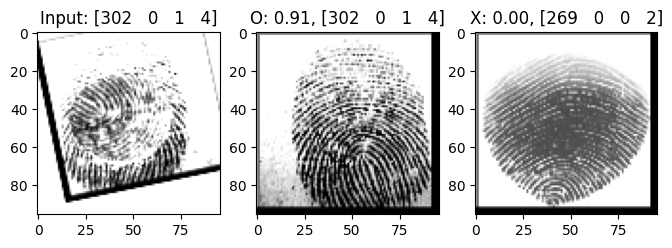

In [30]:

random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    ),
    iaa.Add((-10, 10)),
    iaa.Multiply((0.5, 1.5)),
    iaa.Fliplr(0.5)
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[Label_real_dict[match_key]].reshape((1, 96, 96)).astype(np.float32) / 255.
ry = y_real[Label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])


# unmatched image
unmatch_key, unmatch_idx = random.choice(list(Label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 96, 96)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')
